# Model Exploration

## Imports <a name="imports"></a>

In [2]:
#Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

#Regression Metrics
from sklearn.metrics import mean_squared_error

#Classification Models
from sklearn.cluster import KMeans
from scipy.stats import norm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

#XGBoost
import xgboost as xgb

#Classification Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.classifier import ClassPredictionError
from yellowbrick.regressor import PredictionError
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

import datetime

## Import Data <a name="importData"></a>

In [5]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")

In [6]:
full_df.head()

,Date,Hour,is_event,event_lat,event_lon,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsLat,...,SensorLongitude,SensorLatitude,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,CrowdednessCount
0,2018-03-11,1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.898903,52.373786,2018,1.0,6.123234e-17,0.188227,0.982126,1.224647e-16,-1.000000,0.0
1,2018-03-11,1500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.897193,52.371650,2018,1.0,6.123234e-17,0.188227,0.982126,-7.071068e-01,-0.707107,45.0
2,2018-03-11,1500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.898479,52.375040,2018,1.0,6.123234e-17,0.188227,0.982126,-7.071068e-01,-0.707107,68.0
3,2018-03-11,1500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.898808,52.372369,2018,1.0,6.123234e-17,0.188227,0.982126,-7.071068e-01,-0.707107,25.0
4,2018-03-11,1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.899847,52.374601,2018,1.0,6.123234e-17,0.188227,0.982126,-8.660254e-01,-0.500000,2404.0


### Visualization

In [24]:
x = full.drop(["CrowdednessCount", "Date", "Hour"], axis=1)
y = full["CrowdednessCount"]

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\yellowbrick\features\rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


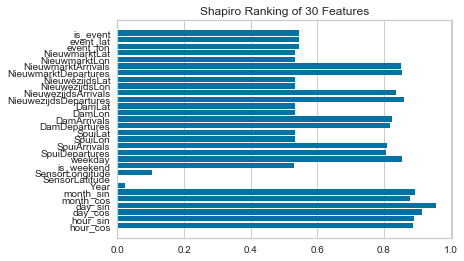

In [25]:
#Rank features - 1D
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

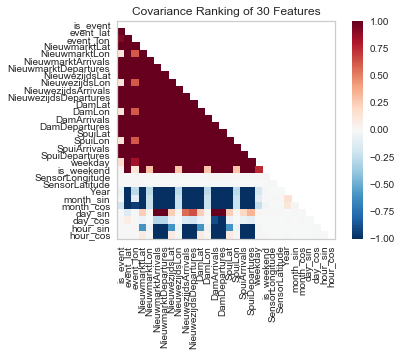

In [26]:
visualizer = Rank2D(algorithm='covariance')
visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

### Split Data into Training/Test and Time Series data

In [27]:
split_date = pd.Timestamp(2018, 12, 31)

TrainTest_df = full[full["Date"] <= split_date].reset_index().drop(columns=["index"])
TimeSeries_df = full[full["Date"] > split_date].reset_index().drop(columns=["index"])

### Criteria for train and test Model <a name="testModel"></a>
Based on the dates.

In [28]:
all_dates = TrainTest_df["Date"].values
np.random.shuffle(all_dates)

In [29]:
split_dates = int(all_dates.size * 0.9)
train_set_dates = all_dates[:split_dates]
test_set_dates = all_dates[split_dates:]

## Regression Models <a name="regModels"></a>

### Train, Test, Evaluation Split

In [30]:
train_df_reg = TrainTest_df[TrainTest_df["Date"].isin(train_set_dates)].drop(columns=["Date", "Hour"])

test_df_reg = TrainTest_df[TrainTest_df["Date"].isin(test_set_dates)].reset_index()

In [122]:
#Train
x_train_reg = train_df_reg.drop(["CrowdednessCount", "Year"], axis=1)
y_train_reg = train_df_reg["CrowdednessCount"]

#Test
x_test_reg = test_df_reg.drop(["CrowdednessCount", "Date", "Hour", "index","Year"], axis=1)
y_test_reg = test_df_reg["CrowdednessCount"]

test_reg_series = test_df_reg[(test_df_reg["Date"] == test_set_dates[2]) & (test_df_reg["SensorLongitude"] == 4.8989027)
                             ].reset_index()
x_test_reg_series = test_reg_series.drop(["CrowdednessCount", "Date", "Hour", "level_0", "index","Year"], axis=1)
y_test_reg_series = test_reg_series["CrowdednessCount"]

#Select data Series set
seriesDate = TimeSeries_df["Date"].values

x_eval_reg = TimeSeries_df.drop(["CrowdednessCount", "Date", "Hour","Year"], axis=1)
y_eval_reg = TimeSeries_df["CrowdednessCount"]

#Subset timeseries
sub_series = TimeSeries_df[(TimeSeries_df["SensorLongitude"] == 4.8989027) & (TimeSeries_df["Date"] == seriesDate[1])
                          ].reset_index()

#Time series
x_series_reg = sub_series.drop(["Date", "Hour","CrowdednessCount", "index", "Year"], axis=1)
y_series_reg = sub_series["CrowdednessCount"]


feature_labels_reg = train_df_reg.columns.values

### Linear Regression <a name="regBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

#### Training

In [123]:
#Give parameters model
reg_base = LinearRegression()

In [124]:
#Fit the model
reg_base.fit(x_train_reg, y_train_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Test

In [125]:
reg_base_score = reg_base.score(x_test_reg, y_test_reg)

y_pred_reg_base = reg_base.predict(x_test_reg)
base_reg_mse = mean_squared_error(y_pred_reg_base, y_test_reg)

print("R^2 Score: ", reg_base_score)
print("MSE: ", base_reg_mse)
print("RMSE: ", np.sqrt(base_reg_mse))

R^2 Score:  0.26735373714107846
MSE:  2254589.308911499
RMSE:  1501.5289903666526


In [126]:
for i in range(10):
    print("Predicted: ", y_pred_reg_base[i], "Real: ", y_test_reg[i])

Predicted:  2511.5152485137805 Real:  130
Predicted:  1843.1285128621385 Real:  200
Predicted:  409.3303315974772 Real:  126
Predicted:  2454.1095553208143 Real:  184
Predicted:  2885.81129668653 Real:  5198
Predicted:  1504.0945776393637 Real:  2192
Predicted:  1035.6652366425842 Real:  4232
Predicted:  797.3750573368743 Real:  1288
Predicted:  1619.4392273277044 Real:  152
Predicted:  1457.9530656291172 Real:  82


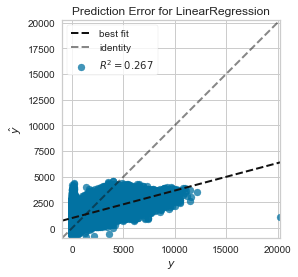

In [127]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [128]:
#Time series
time_pred_reg_lr = reg_base.predict(x_test_reg_series)

time_pred_series_reg_lr = pd.Series(time_pred_reg_lr)
time_real_series_reg_lr = pd.Series(y_test_reg_series)

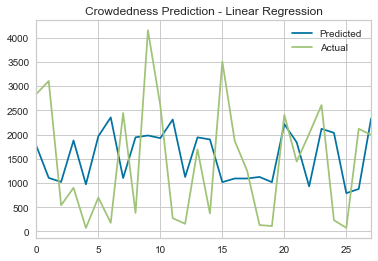

In [129]:
time_pred_series_reg_lr.plot(legend=True, title='Crowdedness Prediction - Linear Regression', label="Predicted")
time_real_series_reg_lr.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [130]:
base_score = reg_base.score(x_eval_reg, y_eval_reg)

y_pred_base = reg_base.predict(x_eval_reg)
base_mse = mean_squared_error(y_pred_base, y_eval_reg)

print("R^2 Score: ", base_score)
print("MSE: ", base_mse)
print("RMSE: ", np.sqrt(base_mse))

R^2 Score:  0.16631215990684467
MSE:  1523484.5123597013
RMSE:  1234.295147993259


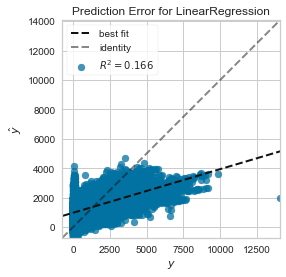

In [131]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [132]:
#Time series
time_pred_lr = reg_base.predict(x_series_reg)

time_pred_series_lr = pd.Series(time_pred_lr)
time_real_series_lr = pd.Series(y_series_reg)

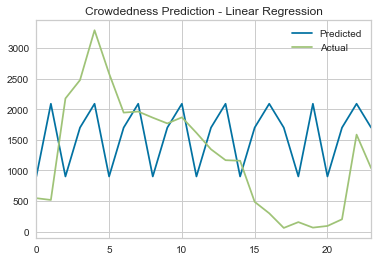

In [133]:
time_pred_series_lr.plot(legend=True, title='Crowdedness Prediction - Linear Regression', label="Predicted")
time_real_series_lr.plot(legend=True, label="Actual")
plt.show()

### Random Forrest Regressor <a name="regRFGModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Parameters
- *N-Estimators*: Number of trees in the model
- *criterion*: loss function
- *n_jobs*: The number of jobs to run in parallel for both fit and predict
- *random_state*: random_state is the seed used by the random number generator
- *bootstrap*: Whether bootstrap samples are used when building trees

#### Training

In [134]:
#Set parameters model
reg_rfg = RandomForestRegressor(n_estimators=500, criterion="mse", n_jobs=100, random_state=42, bootstrap=True, 
                               oob_score=True)

In [135]:
#fit the model
reg_rfg.fit(x_train_reg, y_train_reg)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=100,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

#### Test

In [136]:
#Score the model
reg_rfg_score = reg_rfg.score(x_test_reg, y_test_reg)

#Test
y_pred_reg_rfg = reg_rfg.predict(x_test_reg)
reg_rfg_mse = mean_squared_error(y_pred_reg_rfg, y_test_reg)

print("R^2 Score: ", reg_rfg_score)
print("MSE Test: ", reg_rfg_mse)
print("RMSE Test: ", np.sqrt(reg_rfg_mse))

R^2 Score:  0.9229938877072207
MSE Test:  236972.69241318776
RMSE Test:  486.7984104464473


In [137]:
for i in range(10):
    print("Predicted: ", y_pred_reg_rfg[i], "Real: ", y_test_reg[i])

Predicted:  115.788 Real:  130
Predicted:  182.064 Real:  200
Predicted:  136.856 Real:  126
Predicted:  180.644 Real:  184
Predicted:  5773.736 Real:  5198
Predicted:  2185.044 Real:  2192
Predicted:  3733.768 Real:  4232
Predicted:  1165.276 Real:  1288
Predicted:  1408.456 Real:  152
Predicted:  74.756 Real:  82


In [138]:
#Feature importance
importance = reg_rfg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

weekday-3.59%
hour_sin-10.85%
SensorLatitude-11.08%
day_cos-14.59%
SensorLongitude-39.47%


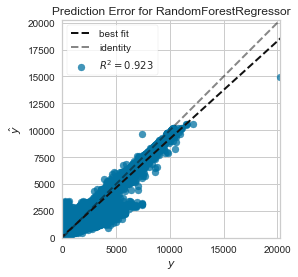

In [139]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [140]:
#Time series
time_pred_reg_rfg = reg_rfg.predict(x_test_reg_series)

time_pred_series_reg_rfg = pd.Series(time_pred_reg_rfg)
time_real_series_reg_rfg = pd.Series(y_test_reg_series)

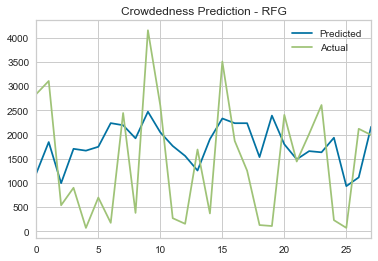

In [141]:
time_pred_series_reg_rfg.plot(legend=True, title='Crowdedness Prediction - RFG', label="Predicted")
time_real_series_reg_rfg.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [142]:
#Score the model
rfg_score = reg_rfg.score(x_eval_reg, y_eval_reg)

#Test
y_pred_rfg = reg_rfg.predict(x_eval_reg)
rfg_mse = mean_squared_error(y_pred_rfg, y_eval_reg)

print("R^2 Score: ", rfg_score)
print("MSE Test: ", rfg_mse)
print("RMSE Test: ", np.sqrt(rfg_mse))

R^2 Score:  0.4409265752602075
MSE Test:  1021653.0251512347
RMSE Test:  1010.7685319355934


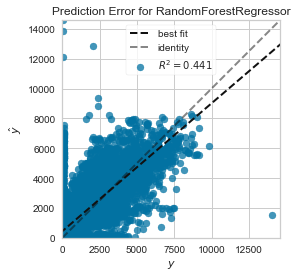

In [143]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [144]:
#Time series
time_pred_rfg = reg_rfg.predict(x_series_reg)

time_pred_series_rfg = pd.Series(time_pred_rfg)
time_real_series_rfg = pd.Series(y_series_reg)

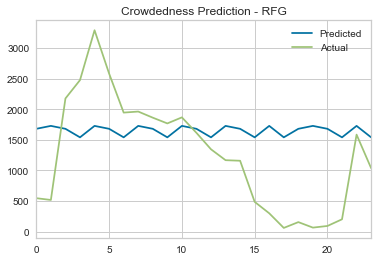

In [57]:
time_pred_series_rfg.plot(legend=True, title='Crowdedness Prediction - RFG', label="Predicted")
time_real_series_rfg.plot(legend=True, label="Actual")
plt.show()

### XGBoost Regressor
Through [SciKit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html) 

#### Training

In [145]:
xgb_reg = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=300, verbosity=1,
                          booster="gbtree", n_jobs=20, random_state=42)

In [146]:
xgb_reg.fit(x_train_reg, y_train_reg)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=20,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, verbosity=1)

#### Test

In [147]:
reg_xgb_score = xgb_reg.score(x_test_reg, y_test_reg)

#Training
y_pred_reg_xgb = xgb_reg.predict(x_test_reg)
reg_xgb_mse = mean_squared_error(y_pred_reg_xgb, y_test_reg)

print("R^2 Score: ", reg_xgb_score)
print("MSE Test: ", reg_xgb_mse)
print("RMSE Test: ", np.sqrt(reg_xgb_mse))

R^2 Score:  0.9075157694095508
MSE Test:  284603.86424203205
RMSE Test:  533.4827684583937


In [148]:
for i in range(10):
    print("Predicted: ", y_pred_reg_xgb[i], "Real: ", y_test_reg[i])

Predicted:  557.47656 Real:  130
Predicted:  288.8931 Real:  200
Predicted:  41.470062 Real:  126
Predicted:  129.7995 Real:  184
Predicted:  5249.5938 Real:  5198
Predicted:  1835.1207 Real:  2192
Predicted:  3374.7776 Real:  4232
Predicted:  1165.3527 Real:  1288
Predicted:  1609.0101 Real:  152
Predicted:  140.25693 Real:  82


In [149]:
#Feature importance
importance = xgb_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

SensorLatitude-9.08%
NieuwmarktLat-9.92%
SensorLongitude-15.59%
hour_sin-19.51%
day_cos-23.01%


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


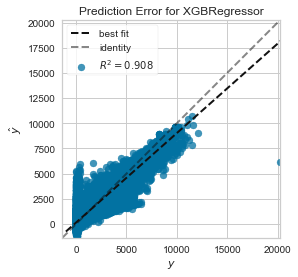

In [150]:
visualizer = PredictionError(xgb_reg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [151]:
#Time series
time_pred_reg_xgb = xgb_reg.predict(x_test_reg_series)

time_pred_series_reg_xgb = pd.Series(time_pred_reg_xgb)
time_real_series_reg_xgb = pd.Series(y_test_reg_series)

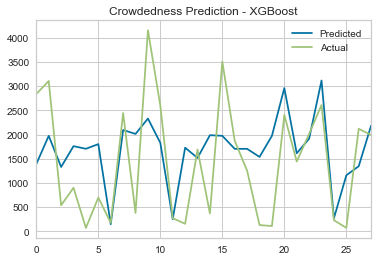

In [152]:
time_pred_series_reg_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_reg_xgb.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [154]:
xgb_score = xgb_reg.score(x_eval_reg, y_eval_reg)

#Training
y_pred_xgb = xgb_reg.predict(x_eval_reg)
xgb_mse = mean_squared_error(y_pred_xgb, y_eval_reg)

print("R^2 Score: ", xgb_score)
print("MSE Test: ", xgb_mse)
print("RMSE Test: ", np.sqrt(xgb_mse))

R^2 Score:  0.4696971616470415
MSE Test:  969077.5398629394
RMSE Test:  984.4173606062316


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


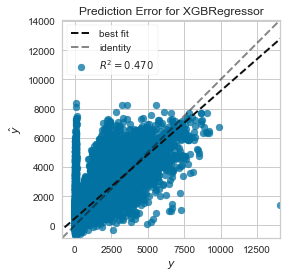

In [155]:
visualizer = PredictionError(xgb_reg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [156]:
#Time series
time_pred_xgb = xgb_reg.predict(x_series_reg)

time_pred_series_xgb = pd.Series(time_pred_xgb)
time_real_series_xgb = pd.Series(y_series_reg)

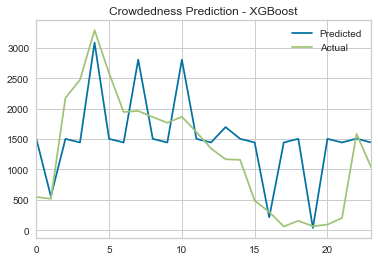

In [157]:
time_pred_series_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_xgb.plot(legend=True, label="Actual")
plt.show()

### Lasso <a name="regABRModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)

#### Training

In [158]:
lasso = LassoCV(n_jobs=50, random_state=42, n_alphas=5, normalize=True, precompute="auto", selection="random")

In [159]:
lasso.fit(x_train_reg, y_train_reg)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=5, n_jobs=50, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='random', tol=0.0001,
    verbose=False)

#### Test

In [160]:
reg_lasso_score=lasso.score(x_test_reg, y_test_reg)

y_pred_reg_lasso = lasso.predict(x_test_reg)
reg_lasso_mse = mean_squared_error(y_pred_reg_lasso, y_test_reg)

print("R^2 Sore: ", reg_lasso_score)
print("MSE: ", reg_lasso_mse)
print("RMSE: ", np.sqrt(reg_lasso_mse))

R^2 Sore:  0.26662517019165843
MSE:  2256831.3448547097
RMSE:  1502.2753891529708


In [161]:
for i in range(10):
    print("Predicted: ", y_pred_reg_lasso[i], "Real: ", y_test_reg[i])

Predicted:  2459.880756785162 Real:  130
Predicted:  1825.0765669494867 Real:  200
Predicted:  392.72878151666373 Real:  126
Predicted:  2433.7284970106557 Real:  184
Predicted:  2870.3316478664055 Real:  5198
Predicted:  1456.0920808678493 Real:  2192
Predicted:  982.0991873955354 Real:  4232
Predicted:  755.1952791195363 Real:  1288
Predicted:  1567.640899230726 Real:  152
Predicted:  1394.4628206761554 Real:  82


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


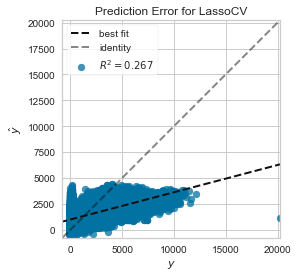

In [162]:
visualizer = PredictionError(lasso)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [163]:
#Time series
time_pred_reg_lasso = lasso.predict(x_test_reg_series)

time_pred_series_reg_lasso = pd.Series(time_pred_reg_lasso)
time_real_series_reg_lasso = pd.Series(y_test_reg_series)

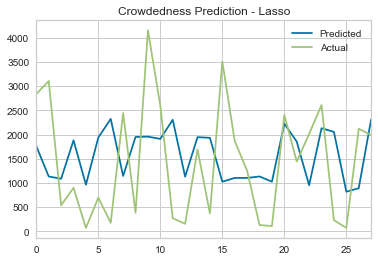

In [164]:
time_pred_series_reg_lasso.plot(legend=True, title='Crowdedness Prediction - Lasso', label="Predicted")
time_real_series_reg_lasso.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [165]:
lasso_score=lasso.score(x_eval_reg, y_eval_reg)

y_pred_lasso = lasso.predict(x_eval_reg)
lasso_mse = mean_squared_error(y_pred_lasso, y_eval_reg)

print("R^2 Sore: ", lasso_score)
print("MSE: ", lasso_mse)
print("RMSE: ", np.sqrt(lasso_mse))

R^2 Sore:  0.1650752350734569
MSE:  1525744.8737755627
RMSE:  1235.2104572806866


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


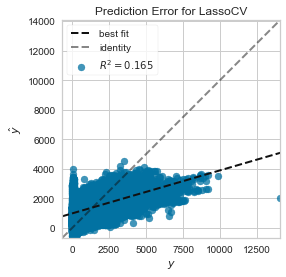

In [166]:
visualizer = PredictionError(lasso)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [167]:
#Time series
time_pred_lasso = lasso.predict(x_series_reg)

time_pred_series_lasso = pd.Series(time_pred_lasso)
time_real_series_lasso = pd.Series(y_series_reg)

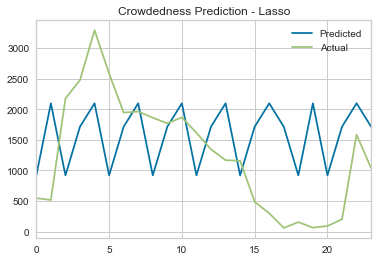

In [168]:
time_pred_series_lasso.plot(legend=True, title='Crowdedness Prediction - Lasso', label="Predicted")
time_real_series_lasso.plot(legend=True, label="Actual")
plt.show()

## Classification Models <a name="classification"></a>

### Change numerical labels to categorical labels <a name="classCatVar"></a>

In [83]:
low_split = TrainTest_df["CrowdednessCount"].quantile(.25)
mid_split = TrainTest_df["CrowdednessCount"].quantile(.5)
high_split = TrainTest_df["CrowdednessCount"].quantile(.75)

In [84]:
clas_dict = TrainTest_df.to_dict("index")

for k, v in clas_dict.items():
    
    if v["CrowdednessCount"] < low_split:
        v["CrowdednessCount"] = 1
    elif v["CrowdednessCount"] >= low_split and v["CrowdednessCount"] < mid_split:
        v["CrowdednessCount"] = 2
    elif v["CrowdednessCount"] >= mid_split and v["CrowdednessCount"] < high_split:
        v["CrowdednessCount"] = 3
    elif v["CrowdednessCount"] >= high_split:
        v["CrowdednessCount"] = 4
    else:
        print (k, " has class error as it fits in none")
    
clas_model_df = pd.DataFrame.from_dict(clas_dict, orient="index")

In [85]:
series_dict = TimeSeries_df.to_dict("index")

for k, v in series_dict.items():
    
    if v["CrowdednessCount"] < low_split:
        v["CrowdednessCount"] = 1
    elif v["CrowdednessCount"] >= low_split and v["CrowdednessCount"] < mid_split:
        v["CrowdednessCount"] = 2
    elif v["CrowdednessCount"] >= mid_split and v["CrowdednessCount"] < high_split:
        v["CrowdednessCount"] = 3
    elif v["CrowdednessCount"] >= high_split:
        v["CrowdednessCount"] = 4
    else:
        print (k, " has class error as it fits in none")
    
TimeSeries_df_clas = pd.DataFrame.from_dict(series_dict, orient="index")    

In [86]:
TimeSeries_df_clas.head()

,Date,Hour,is_event,event_lat,event_lon,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsLat,...,SensorLongitude,SensorLatitude,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,CrowdednessCount
0,2019-03-27,1400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.897717,52.372353,2019,1.0,6.123234e-17,0.448229,0.893919,-0.500000,-0.866025,3
1,2019-03-27,1400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.898053,52.372416,2019,1.0,6.123234e-17,0.448229,0.893919,-0.500000,-0.866025,1
2,2019-03-27,1400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.897908,52.373283,2019,1.0,6.123234e-17,0.448229,0.893919,-0.500000,-0.866025,3
3,2019-03-27,1300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.897193,52.371650,2019,1.0,6.123234e-17,0.448229,0.893919,-0.258819,-0.965926,1
4,2019-03-27,1300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.900441,52.374414,2019,1.0,6.123234e-17,0.448229,0.893919,-0.258819,-0.965926,3


In [87]:
train_df_clas = clas_model_df[clas_model_df["Date"].isin(train_set_dates)].reset_index().drop(columns=["Date", "Hour",
                                                                                                       "index"])

test_df_clas = clas_model_df[clas_model_df["Date"].isin(test_set_dates)].reset_index()

In [88]:
#Train
x_train_clas = train_df_clas.drop(["CrowdednessCount", "Year"], axis=1)
y_train_clas = train_df_clas["CrowdednessCount"]

#Test
x_test_clas = test_df_clas.drop(["CrowdednessCount", "Date", "index", "Hour","Year"], axis=1)
y_test_clas = test_df_clas["CrowdednessCount"]

test_clas_series = test_df_clas[(test_df_clas["Date"] == test_set_dates[2]) & (test_df_reg["SensorLongitude"] == 4.8989027)
                             ].reset_index()
x_test_clas_series = test_clas_series.drop(["CrowdednessCount", "Date", "Hour", "index", "level_0","Year"], axis=1)
y_test_clas_series = test_clas_series["CrowdednessCount"]

#Time series
seriesDate_clas = TimeSeries_df_clas["Date"].values

x_eval_clas = TimeSeries_df_clas.drop(["CrowdednessCount", "Date", "Hour", "Year"], axis=1)
y_eval_clas = TimeSeries_df_clas["CrowdednessCount"]

sub_series_clas = TimeSeries_df_clas[(TimeSeries_df["SensorLongitude"] == 4.8989027) & (TimeSeries_df["Date"] 
                                                                                   == seriesDate_clas[1])].reset_index()

x_series_clas = sub_series_clas.drop(["CrowdednessCount", "Date", "Hour", "index","Year"], axis=1)
y_series_clas = sub_series_clas["CrowdednessCount"]

### Baseline <a name="classBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

Parameters
- *strategy*: "stratified” - generates predictions by respecting the training set’s class distribution.

#### Training

In [89]:
clas_bas = DummyClassifier(strategy="most_frequent", random_state=42)

In [90]:
clas_bas.fit(x_train_clas, y_train_clas)

DummyClassifier(constant=None, random_state=42, strategy='most_frequent')

#### Test

In [91]:
y_pred_clas_bas = clas_bas.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_bas))
print(classification_report(y_test_clas, y_pred_clas_bas))

Accuracy Score:  0.2521793823510913
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     19679
           2       0.25      1.00      0.40     20047
           3       0.00      0.00      0.00     19891
           4       0.00      0.00      0.00     19878

   micro avg       0.25      0.25      0.25     79495
   macro avg       0.06      0.25      0.10     79495
weighted avg       0.06      0.25      0.10     79495



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


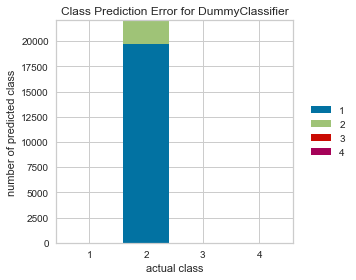

In [92]:
visualizer = ClassPredictionError(
    clas_bas
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [93]:
#Time series
time_pred_bas_clas = clas_bas.predict(x_test_clas_series)

time_pred_series_bas_clas = pd.Series(time_pred_bas_clas)
time_real_series_bas_clas = pd.Series(y_test_clas_series)

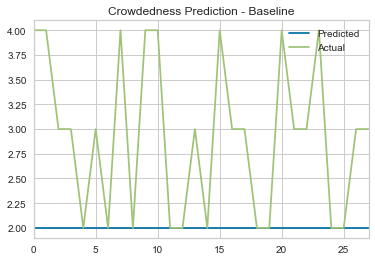

In [94]:
time_pred_series_bas_clas.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_bas_clas.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [95]:
y_pred_bas = clas_bas.predict(x_eval_clas)

print("Accuracy Score: ", accuracy_score(y_eval_clas, y_pred_bas))
print(classification_report(y_eval_clas, y_pred_bas))

Accuracy Score:  0.23055555555555557
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      7076
           2       0.23      1.00      0.37      4980
           3       0.00      0.00      0.00      6378
           4       0.00      0.00      0.00      3166

   micro avg       0.23      0.23      0.23     21600
   macro avg       0.06      0.25      0.09     21600
weighted avg       0.05      0.23      0.09     21600



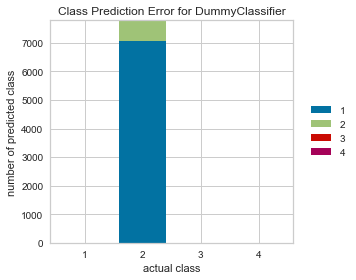

In [96]:
visualizer = ClassPredictionError(
    clas_bas
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_eval_clas, y_eval_clas)
g = visualizer.poof()

In [97]:
#Time series
time_pred_bas = clas_bas.predict(x_series_clas)

time_pred_series_bas = pd.Series(time_pred_bas)
time_real_series_bas = pd.Series(y_series_clas)

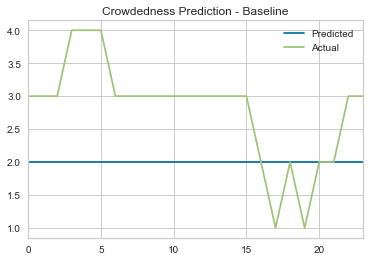

In [98]:
time_pred_series_bas.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_bas.plot(legend=True, label="Actual")
plt.show()

### Random Forrest Classifier <a name="classRFCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

#### Train

In [99]:
clas_rfc = RandomForestClassifier(n_estimators=300, criterion="entropy", n_jobs=50, random_state=42, 
                                  class_weight="balanced", oob_score="True")

In [101]:
clas_rfc.fit(x_train_clas, y_train_clas)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=50, oob_score='True', random_state=42,
            verbose=0, warm_start=False)

#### Test

In [102]:
y_pred_clas_rfc = clas_rfc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_rfc))
print(classification_report(y_test_clas, y_pred_clas_rfc))

Accuracy Score:  0.9253915340587459
              precision    recall  f1-score   support

           1       1.00      0.95      0.97     19679
           2       1.00      0.88      0.93     20047
           3       0.84      0.93      0.89     19891
           4       0.89      0.94      0.91     19878

   micro avg       0.93      0.93      0.93     79495
   macro avg       0.93      0.93      0.93     79495
weighted avg       0.93      0.93      0.93     79495



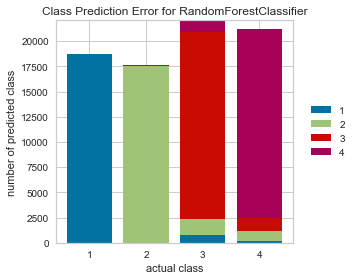

In [103]:
visualizer = ClassPredictionError(
    clas_rfc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [104]:
#Time series
time_pred_rfc_clas = clas_rfc.predict(x_test_clas_series)

time_pred_series_rfc_clas = pd.Series(time_pred_rfc_clas)
time_real_series_rfc_clas = pd.Series(y_test_clas_series)

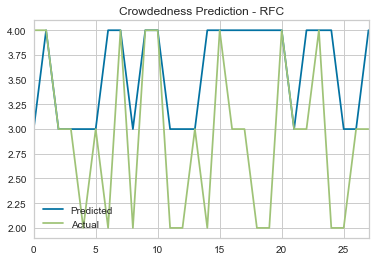

In [105]:
time_pred_series_rfc_clas.plot(legend=True, title='Crowdedness Prediction - RFC', label="Predicted")
time_real_series_rfc_clas.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [106]:
y_pred_rfc = clas_rfc.predict(x_eval_clas)

print("Accuracy Score: ", accuracy_score(y_eval_clas, y_pred_rfc))
print(classification_report(y_eval_clas, y_pred_rfc))

Accuracy Score:  0.6674074074074074
              precision    recall  f1-score   support

           1       0.86      0.64      0.73      7076
           2       0.63      0.59      0.61      4980
           3       0.64      0.66      0.65      6378
           4       0.54      0.88      0.67      3166

   micro avg       0.67      0.67      0.67     21600
   macro avg       0.67      0.69      0.66     21600
weighted avg       0.70      0.67      0.67     21600



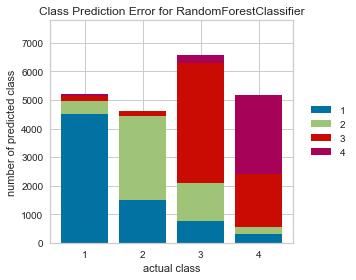

In [107]:
visualizer = ClassPredictionError(
    clas_rfc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_eval_clas, y_eval_clas)
g = visualizer.poof()

In [108]:
#Time series
time_pred_rfc = clas_rfc.predict(x_series_clas)

time_pred_series_rfc = pd.Series(time_pred_rfc)
time_real_series_rfc = pd.Series(y_series_clas)

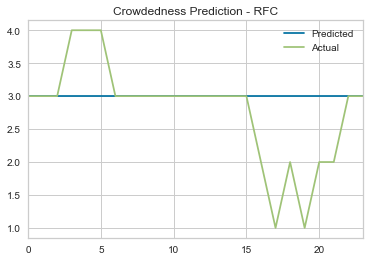

In [109]:
time_pred_series_rfc.plot(legend=True, title='Crowdedness Prediction - RFC', label="Predicted")
time_real_series_rfc.plot(legend=True, label="Actual")
plt.show()

### XGBoost 
Implement [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

#### Training

In [110]:
xgb_clas = xgb.XGBClassifier(random_state=42, n_estimators=300, max_depth=12, 
                              learning_rate=0.1, booster="gbtree", n_jobs=50)

In [111]:
xgb_clas.fit(x_train_clas, y_train_clas)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=50, nthread=None, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

#### Test

In [112]:
y_pred_clas_xgb = xgb_clas.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_xgb))
print(classification_report(y_test_clas, y_pred_clas_xgb))

Accuracy Score:  0.9475564500912007
              precision    recall  f1-score   support

           1       1.00      0.97      0.98     19679
           2       1.00      0.91      0.95     20047
           3       0.88      0.96      0.91     19891
           4       0.93      0.95      0.94     19878

   micro avg       0.95      0.95      0.95     79495
   macro avg       0.95      0.95      0.95     79495
weighted avg       0.95      0.95      0.95     79495



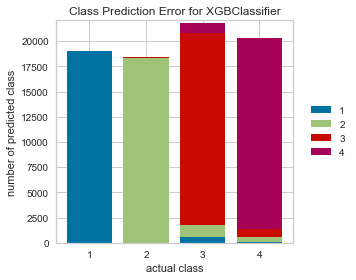

In [113]:
visualizer = ClassPredictionError(
    xgb_clas, 
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [114]:
#Time series
time_pred_clas_xgb = xgb_clas.predict(x_test_clas_series)

time_pred_series_clas_xgb = pd.Series(time_pred_clas_xgb)
time_real_series_clas_xgb = pd.Series(y_test_clas_series)

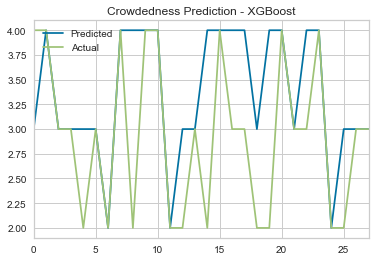

In [115]:
time_pred_series_clas_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_clas_xgb.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [116]:
y_pred_xgb = xgb_clas.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_xgb))
print(classification_report(y_series_clas, y_pred_xgb))

Accuracy Score:  0.7083333333333334
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.50      0.25      0.33         4
           3       0.70      0.93      0.80        15
           4       1.00      0.33      0.50         3

   micro avg       0.71      0.71      0.71        24
   macro avg       0.80      0.50      0.57        24
weighted avg       0.73      0.71      0.67        24



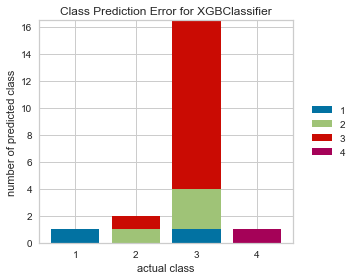

In [117]:
visualizer = ClassPredictionError(
    xgb_clas, 
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [118]:
#Time series
time_pred_xgb = xgb_clas.predict(x_series_clas)

time_pred_series_xgb = pd.Series(time_pred_xgb)
time_real_series_xgb = pd.Series(y_series_clas)

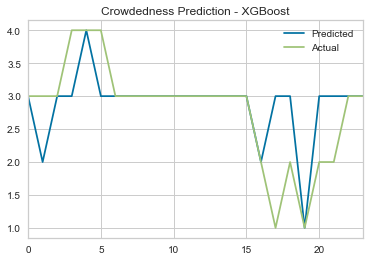

In [119]:
time_pred_series_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_xgb.plot(legend=True, label="Actual")
plt.show()

### SVC 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

#### Training

In [169]:
clas_svc = SVC(kernel="rbf", random_state=42, class_weight="balanced", C=0.5, decision_function_shape="ovo")

In [ ]:
clas_svc.fit(x_train_clas, y_train_clas)

#### Test

In [328]:
y_pred_clas_svc = clas_svc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_svc))
print(classification_report(y_test_clas, y_pred_clas_svc))

Accuracy Score:  0.8012931034482759
              precision    recall  f1-score   support

           1       0.95      0.78      0.86      3484
           2       0.80      0.73      0.76      3475
           3       0.63      0.96      0.76      3475
           4       0.99      0.74      0.85      3486

   micro avg       0.80      0.80      0.80     13920
   macro avg       0.84      0.80      0.81     13920
weighted avg       0.84      0.80      0.81     13920



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


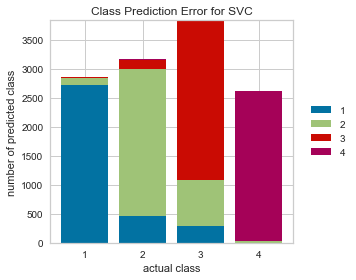

In [329]:
visualizer = ClassPredictionError(
    clas_svc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [330]:
#Time series
time_pred_clas_svc = clas_svc.predict(x_test_clas_series)

time_pred_series_clas_svc = pd.Series(time_pred_clas_svc)
time_real_series_clas_svc = pd.Series(y_test_clas_series)

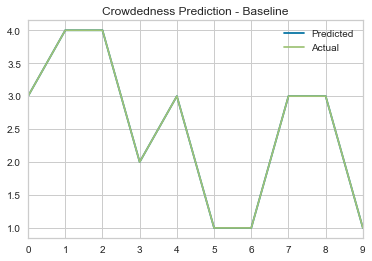

In [331]:
time_pred_series_clas_svc.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_clas_svc.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [332]:
y_pred_svc = clas_svc.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_svc))
print(classification_report(y_series_clas, y_pred_svc))

Accuracy Score:  0.4583333333333333
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.46      1.00      0.63        11
           4       0.00      0.00      0.00         6

   micro avg       0.46      0.46      0.46        24
   macro avg       0.11      0.25      0.16        24
weighted avg       0.21      0.46      0.29        24



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


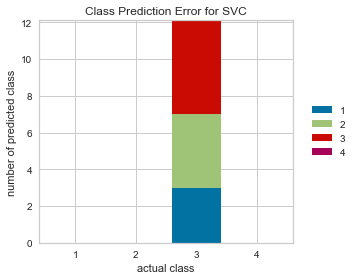

In [333]:
visualizer = ClassPredictionError(
    clas_svc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [334]:
#Time series
time_pred_svc = clas_svc.predict(x_series_clas)

time_pred_series_svc = pd.Series(time_pred_svc)
time_real_series_svc = pd.Series(y_series_clas)

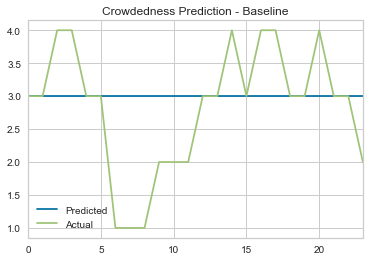

In [335]:
time_pred_series_svc.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_svc.plot(legend=True, label="Actual")
plt.show()

### Voting Classifier <a name="classVCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)

This classifier combines the classifications of the [Random Forrest Classification](#classRFCModel) and [Gradient Boosting Classification](#classGBCModel) by classifying each instance with the one of the classes given by the models. 

#### Training

In [178]:
#List estimator models
estimators = [("rfc", clas_rfc), ("gbc", clas_gbc)]

clas_vc = VotingClassifier(estimators=estimators, voting="soft", n_jobs=20,weights=[1, 1])

In [179]:
clas_vc.fit(x_train_clas, y_train_clas)

VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=20, voting='soft', weights=[1, 1])

#### Test

In [180]:
y_pred_vc = clas_vc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_vc))
print(classification_report(y_test_clas, y_pred_vc))

Accuracy Score:  0.9581140508975561
              precision    recall  f1-score   support

           1       0.99      0.97      0.98      3475
           2       0.94      0.94      0.94      3460
           3       0.95      0.94      0.95      3474
           4       0.95      0.98      0.97      3462

   micro avg       0.96      0.96      0.96     13871
   macro avg       0.96      0.96      0.96     13871
weighted avg       0.96      0.96      0.96     13871



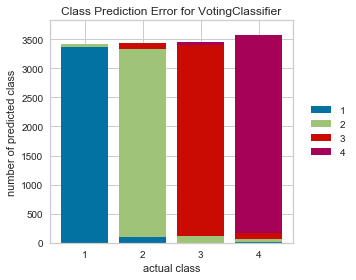

In [181]:
visualizer = ClassPredictionError(
    clas_vc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [182]:
#Time series
time_pred_clas_vc = clas_vc.predict(x_test_clas_series)

time_pred_series_clas_vc = pd.Series(time_pred_clas_vc)
time_real_series_clas_vc = pd.Series(y_test_clas_series)

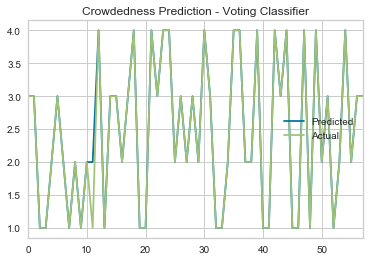

In [183]:
time_pred_series_clas_vc.plot(legend=True, title='Crowdedness Prediction - Voting Classifier', label="Predicted")
time_real_series_clas_vc.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [184]:
y_pred_vc = clas_vc.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_vc))
print(classification_report(y_series_clas, y_pred_vc))

Accuracy Score:  0.5
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         3
           2       0.43      0.75      0.55         4
           3       0.67      0.36      0.47        11
           4       0.40      0.33      0.36         6

   micro avg       0.50      0.50      0.50        24
   macro avg       0.50      0.61      0.51        24
weighted avg       0.54      0.50      0.48        24



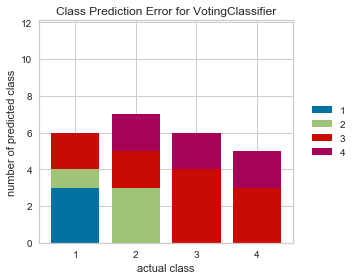

In [185]:
visualizer = ClassPredictionError(
    clas_vc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [186]:
#Time series
time_pred_vc = clas_vc.predict(x_series_clas)

time_pred_series_vc = pd.Series(time_pred_vc)
time_real_series_vc = pd.Series(y_series_clas)

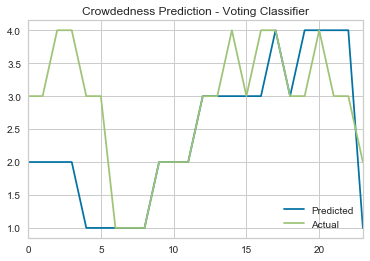

In [187]:
time_pred_series_vc.plot(legend=True, title='Crowdedness Prediction - Voting Classifier', label="Predicted")
time_real_series_vc.plot(legend=True, label="Actual")
plt.show()